# Forecasting Bike Rentals in NYC

Our goal is to forecast the number of bike rides in New York City in a given day. We aim to investigate weather and seasonality effects on bike ridership. 

Datasets used:
1.   [Citi Bike System Data ](https://www.citibikenyc.com/system-data)
2.   [NOAA Weather data](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt)



 ## Setup

In [53]:
from datetime import datetime, timedelta
from google.colab import drive
from prettytable import PrettyTable
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.metrics import precision_score, accuracy_score, classification_report, roc_auc_score, roc_curve, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import graphviz
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import pydot
import seaborn as sns

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Load data

**Read weather data from NOOA dataset**

In [3]:
path = '/content/drive/My Drive/CMPE 255 Project/data/nooa_weather/nooa_nyc_weather_features.csv'
#from os import listdir
#from os.path import isfile, join
#onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
#print(onlyfiles)
weather_features = pd.read_csv(path)
weather_features['Date'] = pd.to_datetime(weather_features['Date'], infer_datetime_format=True)
weather_features

,Date,TMAX,TMIN,PRCP,SNOW,AWND,SNWD,WDF2,WDF5,WSF2,WSF5
0,2015-01-01,39,-27,0,0.0,32.0,0,260.0,250.0,76.0,139.0
1,2015-01-02,56,17,0,0.0,32.0,0,260.0,310.0,67.0,112.0
2,2015-01-03,56,6,180,0.0,29.0,0,80.0,70.0,54.0,81.0
3,2015-01-04,133,50,76,0.0,29.0,0,280.0,260.0,130.0,206.0
4,2015-01-05,94,-60,0,0.0,47.0,0,280.0,300.0,107.0,170.0
...,...,...,...,...,...,...,...,...,...,...,...
2096,2020-09-27,261,194,8,0.0,NaN,0,NaN,NaN,NaN,NaN
2097,2020-09-28,250,206,5,0.0,NaN,0,NaN,NaN,NaN,NaN
2098,2020-09-29,233,194,119,0.0,NaN,0,NaN,NaN,NaN,NaN
2099,2020-09-30,217,156,290,0.0,28.0,0,270.0,160.0,76.0,121.0


**Read aggregated ride count**

In [4]:
rides_tmp = []
years = range(2013, 2021)
for y in years:
  path = '/content/drive/My Drive/CMPE 255 Project/data/citibikes/rides_count_agg_{}.csv'.format(y)
  rides_y = pd.read_csv(path)
  rides_tmp.append(rides_y)

rides = pd.concat(rides_tmp)
rides['date'] = pd.to_datetime(rides['date'], infer_datetime_format=True)
rides = rides[rides.date < '2020-03-01']
rides.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4442 entries, 0 to 119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      4442 non-null   datetime64[ns]
 1   usertype  4442 non-null   object        
 2   numrides  4442 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 138.8+ KB


## Data preprocessing

**Missing value analysis of weather data**


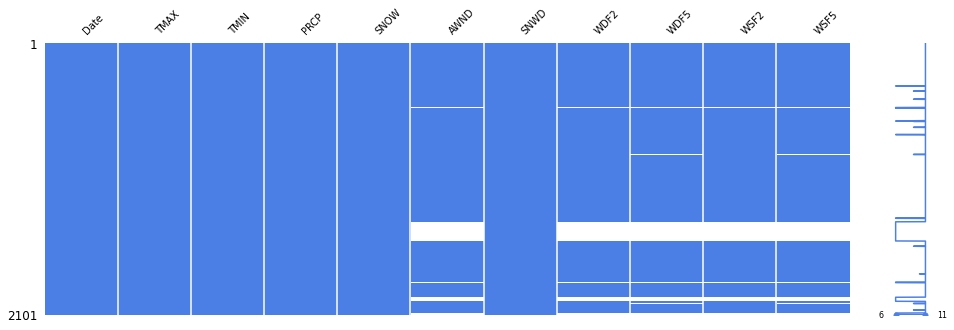

In [5]:
msno.matrix(weather_features, figsize=(16,5), fontsize=10, color=(0.3,0.5,0.9)) 


**Outlier analysis of weather data**

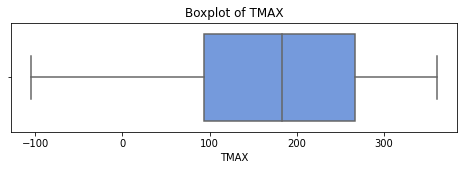

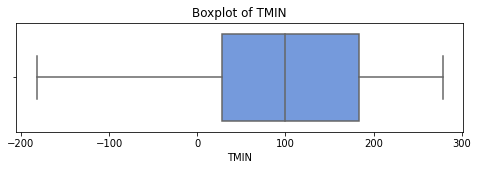

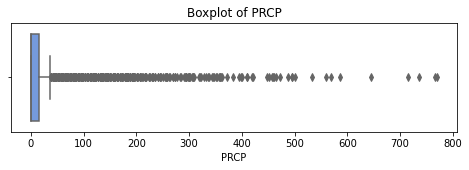

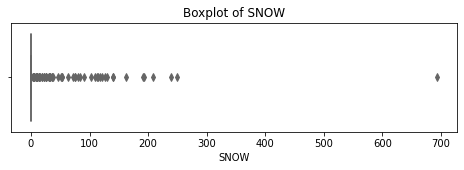

In [6]:
cols = ['TMAX','TMIN','PRCP', 'SNOW'] #'AWND','SNWD', 'WDF2', 'WDF5', 'WSF2',	'WSF5'
for col in cols:
    plt.figure(figsize=(8, 2))
    sns.boxplot(x=col,data=weather_features, color="cornflowerblue")
    plt.title('Boxplot of '+col)
    plt.show()


**Correlation analysis**

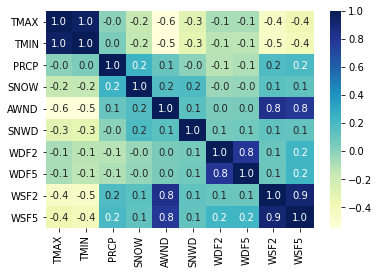

In [7]:
sns.heatmap(weather_features.corr(), annot=True, fmt=".1f", cmap="YlGnBu");

**Ride data visualization**

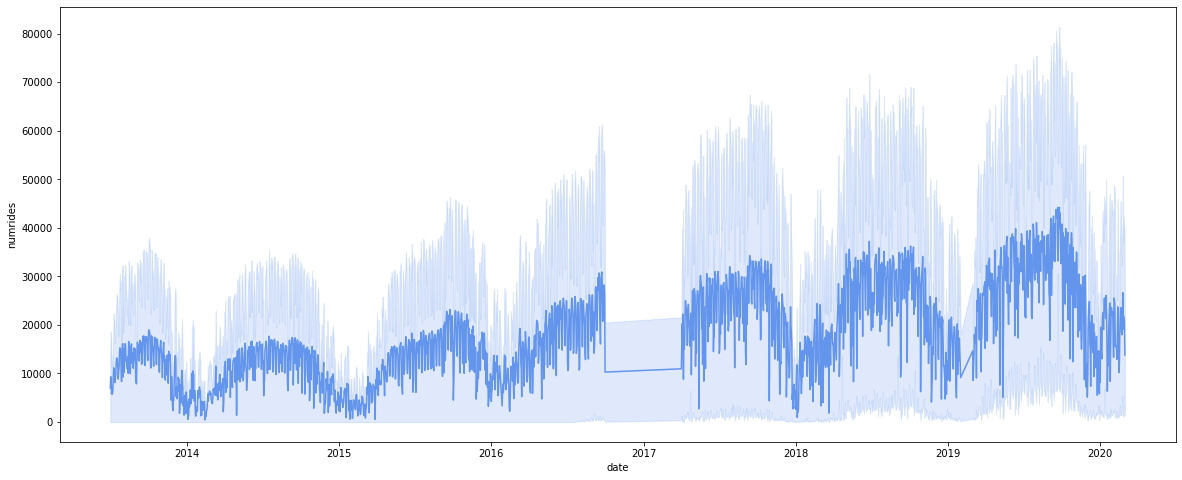

In [9]:
plt.figure(figsize=(20,8))
sns.lineplot(data=rides,x='date', y='numrides', color="cornflowerblue")


**Outlier analysis of total ride count**

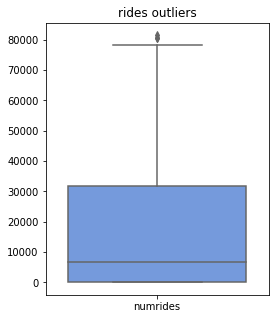

In [11]:

fig,ax=plt.subplots(figsize=(4,5))
sns.boxplot(data=rides[['numrides']], color="cornflowerblue")
ax.set_title('rides outliers')
plt.show()

## Data integration
Merge ride data and weather data 


In [12]:
rides = rides.merge(weather_features, left_on='date', right_on='Date').drop(['Date'], axis=1)
rides = rides.fillna(rides.mean())
rides.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


,date,usertype,numrides,TMAX,TMIN,PRCP,SNOW,AWND,SNWD,WDF2,WDF5,WSF2,WSF5
0,2015-01-01,Customer,0,39,-27,0,0.0,32.0,0,260.0,250.0,76.0,139.0
1,2015-01-01,Subscriber,4651,39,-27,0,0.0,32.0,0,260.0,250.0,76.0,139.0
2,2015-01-02,Customer,0,56,17,0,0.0,32.0,0,260.0,310.0,67.0,112.0
3,2015-01-02,Subscriber,10662,56,17,0,0.0,32.0,0,260.0,310.0,67.0,112.0
4,2015-01-03,Customer,0,56,6,180,0.0,29.0,0,80.0,70.0,54.0,81.0


**Add new columns for day_of_week, week_of_year, month etc**


In [13]:
rides['day_of_week'] = pd.DatetimeIndex(rides['date']).dayofweek
rides['week_of_year'] = pd.DatetimeIndex(rides['date']).week
rides['month'] = pd.DatetimeIndex(rides['date']).month        
rides['year'] = pd.DatetimeIndex(rides['date']).year
rides.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


,date,usertype,numrides,TMAX,TMIN,PRCP,SNOW,AWND,SNWD,WDF2,WDF5,WSF2,WSF5,day_of_week,week_of_year,month,year
0,2015-01-01,Customer,0,39,-27,0,0.0,32.0,0,260.0,250.0,76.0,139.0,3,1,1,2015
1,2015-01-01,Subscriber,4651,39,-27,0,0.0,32.0,0,260.0,250.0,76.0,139.0,3,1,1,2015
2,2015-01-02,Customer,0,56,17,0,0.0,32.0,0,260.0,310.0,67.0,112.0,4,1,1,2015
3,2015-01-02,Subscriber,10662,56,17,0,0.0,32.0,0,260.0,310.0,67.0,112.0,4,1,1,2015
4,2015-01-03,Customer,0,56,6,180,0.0,29.0,0,80.0,70.0,54.0,81.0,5,1,1,2015


**Encoding the date fields into binary vectors**


In [14]:
# Decision tree can handle both categorical and numerical data, but sklearn library cannot.
cols = ['day_of_week', 'week_of_year', 'month']
for col in cols:
    dummy_col = pd.get_dummies(rides[col], prefix=col, drop_first=False)
    rides = pd.concat([rides, dummy_col], axis=1)

rides = rides.drop(cols, axis=1)
rides.head()

,date,usertype,numrides,TMAX,TMIN,PRCP,SNOW,AWND,SNWD,WDF2,WDF5,WSF2,WSF5,year,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,week_of_year_1,week_of_year_2,week_of_year_3,week_of_year_4,week_of_year_5,week_of_year_6,week_of_year_7,week_of_year_8,week_of_year_9,week_of_year_10,week_of_year_11,week_of_year_12,week_of_year_13,week_of_year_14,week_of_year_15,week_of_year_16,week_of_year_17,week_of_year_18,week_of_year_19,...,week_of_year_26,week_of_year_27,week_of_year_28,week_of_year_29,week_of_year_30,week_of_year_31,week_of_year_32,week_of_year_33,week_of_year_34,week_of_year_35,week_of_year_36,week_of_year_37,week_of_year_38,week_of_year_39,week_of_year_40,week_of_year_41,week_of_year_42,week_of_year_43,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2015-01-01,Customer,0,39,-27,0,0.0,32.0,0,260.0,250.0,76.0,139.0,2015,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2015-01-01,Subscriber,4651,39,-27,0,0.0,32.0,0,260.0,250.0,76.0,139.0,2015,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2015-01-02,Customer,0,56,17,0,0.0,32.0,0,260.0,310.0,67.0,112.0,2015,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2015-01-02,Subscriber,10662,56,17,0,0.0,32.0,0,260.0,310.0,67.0,112.0,2015,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,2015-01-03,Customer,0,56,6,180,0.0,29.0,0,80.0,70.0,54.0,81.0,2015,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


**Separating data into subscriber and customer datasets**

In [15]:
subscriber_rides = rides[rides['usertype'] == 'Subscriber']
customer_rides = rides[(rides['usertype'] == 'Customer') & (rides['date'] >= '2016-01-01')]

subscriber_rides.head()

,date,usertype,numrides,TMAX,TMIN,PRCP,SNOW,AWND,SNWD,WDF2,WDF5,WSF2,WSF5,year,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,week_of_year_1,week_of_year_2,week_of_year_3,week_of_year_4,week_of_year_5,week_of_year_6,week_of_year_7,week_of_year_8,week_of_year_9,week_of_year_10,week_of_year_11,week_of_year_12,week_of_year_13,week_of_year_14,week_of_year_15,week_of_year_16,week_of_year_17,week_of_year_18,week_of_year_19,...,week_of_year_26,week_of_year_27,week_of_year_28,week_of_year_29,week_of_year_30,week_of_year_31,week_of_year_32,week_of_year_33,week_of_year_34,week_of_year_35,week_of_year_36,week_of_year_37,week_of_year_38,week_of_year_39,week_of_year_40,week_of_year_41,week_of_year_42,week_of_year_43,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
1,2015-01-01,Subscriber,4651,39,-27,0,0.0,32.0,0,260.0,250.0,76.0,139.0,2015,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2015-01-02,Subscriber,10662,56,17,0,0.0,32.0,0,260.0,310.0,67.0,112.0,2015,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,2015-01-03,Subscriber,4252,56,6,180,0.0,29.0,0,80.0,70.0,54.0,81.0,2015,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7,2015-01-04,Subscriber,7456,133,50,76,0.0,29.0,0,280.0,260.0,130.0,206.0,2015,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9,2015-01-05,Subscriber,14256,94,-60,0,0.0,47.0,0,280.0,300.0,107.0,170.0,2015,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


## Random forest data modeling

**Find test train split date**

Subscriber data is selected for modeling

Latest 365 days is selected for testing

In [114]:
holdout_period = 365
max_date = subscriber_rides[['date']].max()
split_date = max_date - timedelta(days=holdout_period)
split_date = split_date[0].strftime('%Y-%m-%d')
print(split_date)

2019-03-01


In [115]:
# Split Date into 180 days
holdout_period = 180
max_date = subscriber_rides[['date']].max()
six_month_date = max_date - timedelta(days=holdout_period)
six_month_date = six_month_date[0].strftime('%Y-%m-%d')
print(six_month_date)

2019-09-02


**Train and test data split**

In [116]:
# Test set 1 year
X0 = subscriber_rides.drop(['date','usertype', 'year', 'numrides'], axis=1)
y0 = subscriber_rides['numrides']
train = subscriber_rides.loc[subscriber_rides.date <= split_date].copy()
test = subscriber_rides.loc[subscriber_rides.date > split_date].copy()
X0_train = train.drop(['date','usertype', 'year', 'numrides'], axis=1)
y0_train = train['numrides']
X0_test = test.drop(['date','usertype', 'year', 'numrides'], axis=1)
y0_test = test['numrides']

In [117]:
X = subscriber_rides.drop(['date','usertype', 'year', 'numrides'], axis=1)
y = subscriber_rides['numrides']
train = subscriber_rides.loc[subscriber_rides.date <= split_date].copy()
test = subscriber_rides.loc[subscriber_rides.date > split_date].copy()
X_train = train.drop(['date','usertype', 'year', 'numrides'], axis=1)
y_train = train['numrides']
X_test = test.drop(['date','usertype', 'year', 'numrides'], axis=1)
y_test = test['numrides']

**Random forest regressor with GridSearchCV**

In [19]:
from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1000, stop = 1000, num = 1)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(80, 80, num = 1)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [80, None],
 'max_features': ['sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [1000]}


In [20]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = GridSearchCV(rf, random_grid, cv = 2, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  1.8min finished


{'bootstrap': False,
 'max_depth': 80,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1000}

In [118]:
# Print the best parameters and score
print("Random forest best params: {}".format(rf_random.best_params_))
print("Best score/R-Squared::{}".format(rf_random.best_score_))

Random forest best params: {'bootstrap': False, 'max_depth': 80, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}
Best score/R-Squared::-0.30353921838382947


**Pick best estimator and train**

In [119]:
rf_model = rf_random.best_estimator_
rf_model.fit(X_train, y_train)

rf_model0 = rf_random.best_estimator_
rf_model0.fit(X0_train, y0_train)

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=80, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

**Predictions**

In [120]:
# Predicting # of rides given date/weather features (1year)
y_pred0 = rf_model0.predict(X0_test)

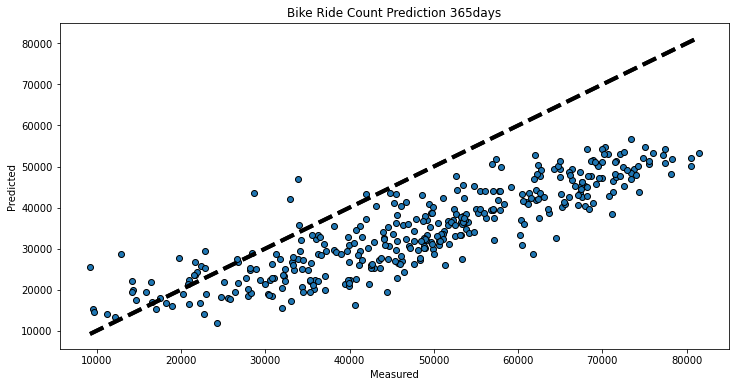

In [121]:
# Plot Prediction for (365 days)
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(y0_test, y_pred0, edgecolors=(0, 0, 0))
ax.plot([y0_test.min(), y0_test.max()], [y0_test.min(), y0_test.max()], 'k--', lw=4)
ax.plot([y0_test.min(), y0_test.max()], [y0_test.min(), y0_test.max()], 'k--', lw=4)
ax.set_title('Bike Ride Count Prediction 365days')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [122]:
y_pred = rf_model.predict(X_test)

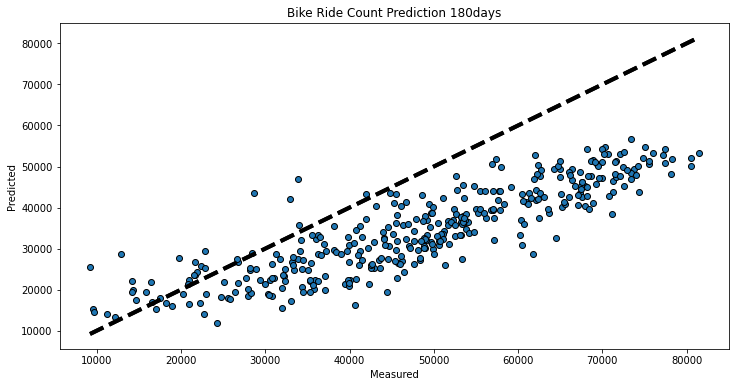

In [123]:
# Plot Prediction for (180 days) 
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_title('Bike Ride Count Prediction 180days')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

##Model evaluation

In [124]:
print('R square:', metrics.r2_score(y_test, y_pred))
print('Adjusted r square:', 1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-X_train.shape[1]-1))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('MAE', mean_absolute_error(y_test, y_pred))
print('MAPE:', np.mean(np.abs((y_test - y_pred) / y_test)))
print('MDAPE:', np.median(np.abs((y_test - y_pred) / y_test))) 


R square: 0.014234416054667465
Adjusted r square: -0.2724066402698617
MSE: 269840987.38423526
RMSE: 16426.837412729063
MAE 14655.461815753424
MAPE: 0.2985888962369678
MDAPE: 0.30438280696992426


**Feature importances**

[0.170328   0.14347473 0.05228674 0.01114248 0.07378037 0.04252405
 0.0334818  0.03275008 0.05100216 0.04521631 0.00562411 0.00796386
 0.01134235 0.01004199 0.00512382 0.03781237 0.05347503 0.00226967
 0.00091162 0.00084388 0.00118249 0.00104537 0.00182937 0.00067435
 0.00081115 0.00108952 0.000879   0.00101626 0.00071419 0.00111109
 0.00150204 0.00112435 0.00369362 0.00138098 0.00231749 0.00301372
 0.00169007 0.00208621 0.00216244 0.00132468 0.00157606 0.00208803
 0.00177409 0.00364172 0.00133231 0.00121744 0.00156545 0.00131586
 0.00088713 0.00110339 0.00121443 0.00205253 0.00174254 0.00300227
 0.00323357 0.00242897 0.00296963 0.00171444 0.00298943 0.00279889
 0.00376979 0.00222238 0.00107781 0.00132419 0.00266862 0.00155303
 0.00131214 0.00084209 0.0093706  0.00080686 0.0227182  0.01490452
 0.00924422 0.00479928 0.00461731 0.00452109 0.00325744 0.00424479
 0.01331734 0.01669583 0.00652284 0.00751771]


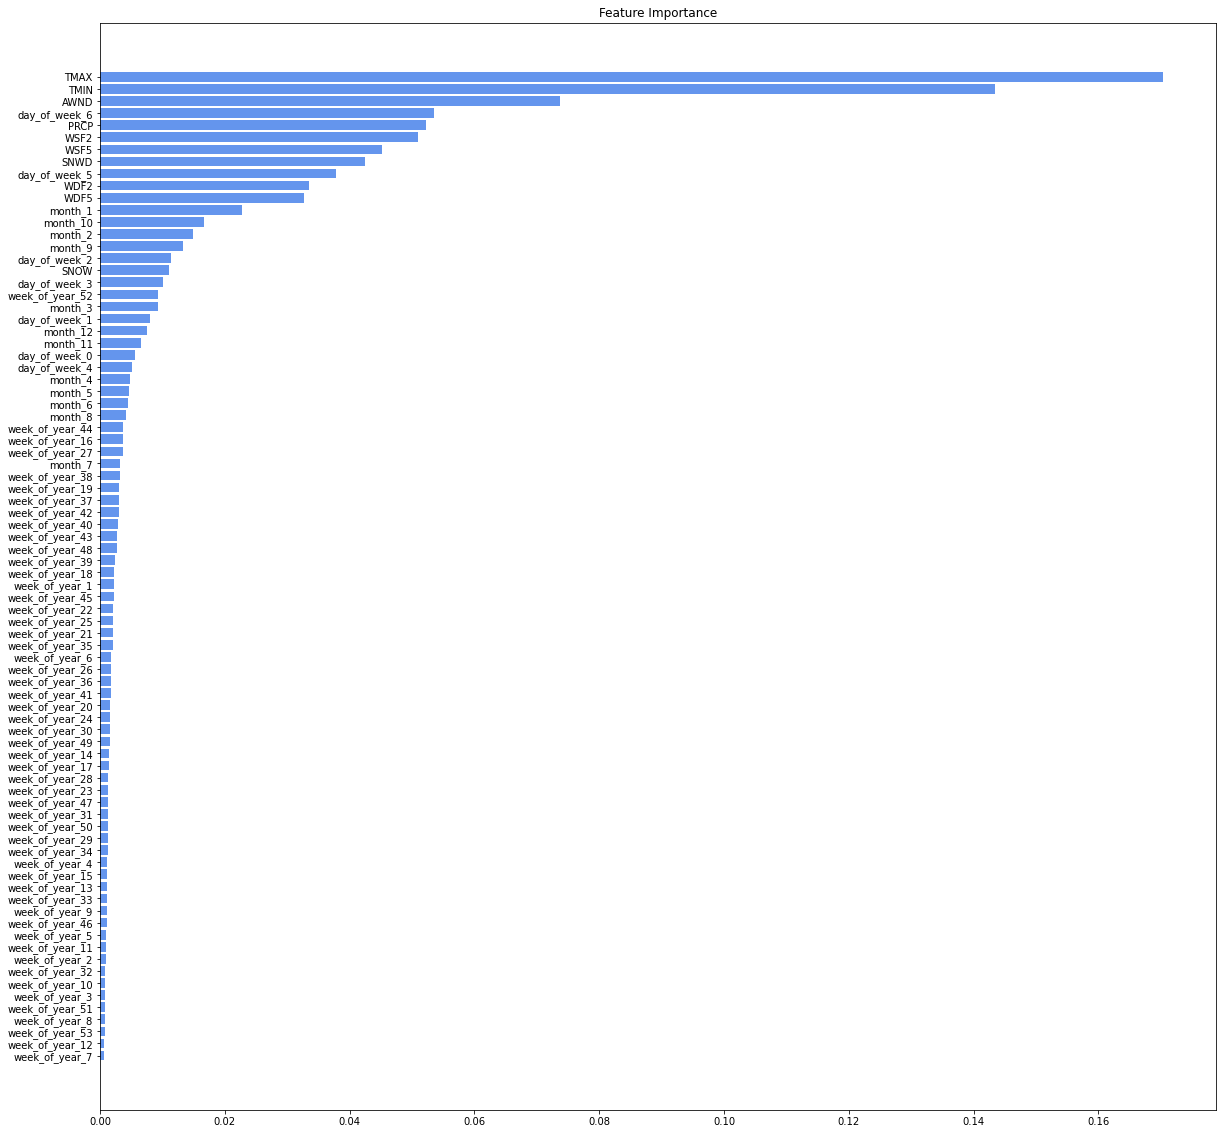

In [125]:

# Print coefficients
rf_features = rf_model.feature_importances_
print(rf_features)

# Sort feature importances
indices = np.argsort(rf_features)[::1]

# Sorting features in the order of importance
names = [X_train.columns[i] for i in indices]

fig = plt.figure(figsize=(20,20))
plt.title("Feature Importance")

plt.barh(range(pd.DataFrame(X_train).shape[1]),rf_features[indices],align = 'center', color="cornflowerblue")
plt.yticks(range(pd.DataFrame(X_train).shape[1]), names)
plt.show()


**Actual vs Observed values**

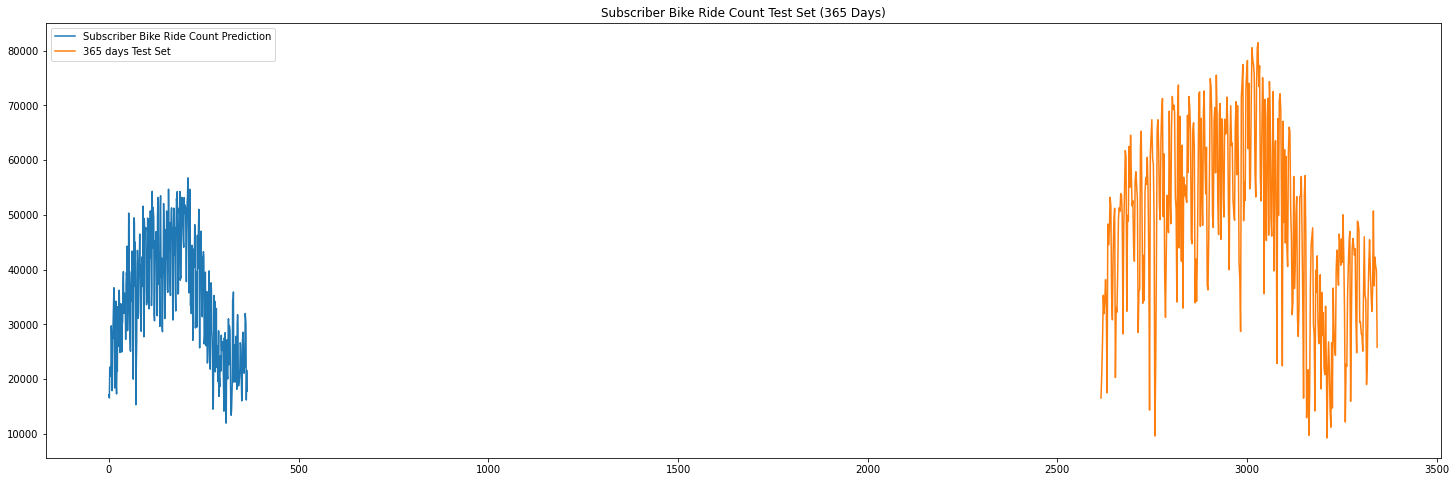

In [126]:
fig, ax = plt.subplots(figsize=(25,8))
ax.plot(y_pred0, label='Subscriber Bike Ride Count Prediction')
ax.plot(y0_test,label='365 days Test Set')
plt.title('Subscriber Bike Ride Count Test Set (365 Days)')
ax.legend()

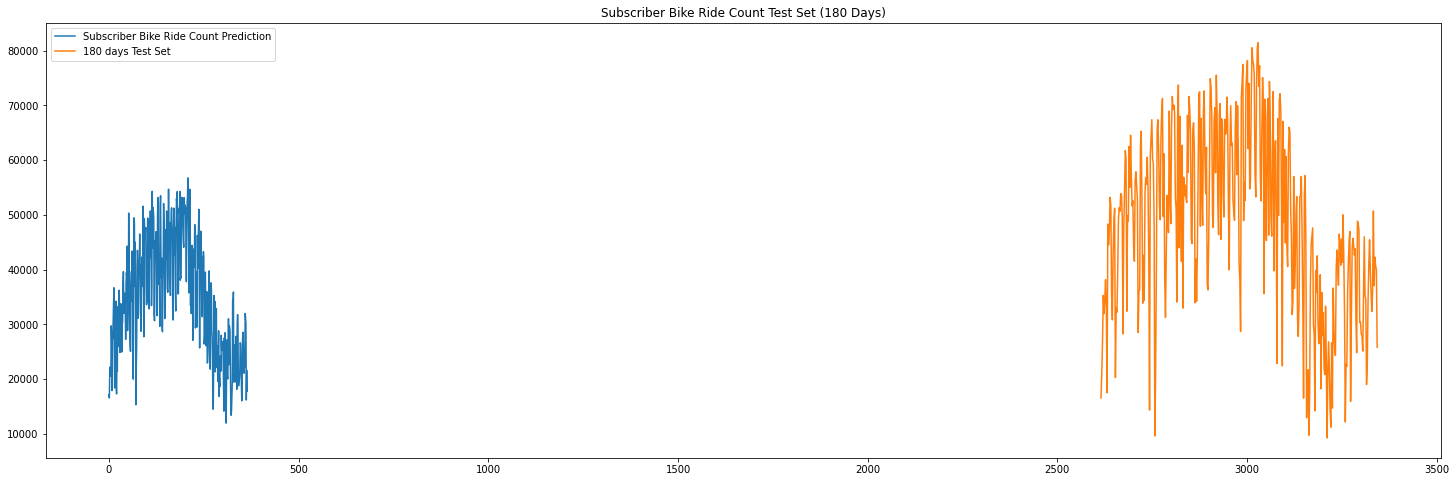

In [127]:
fig, ax = plt.subplots(figsize=(25,8))
ax.plot(y_pred, label='Subscriber Bike Ride Count Prediction')
ax.plot(y_test,label='180 days Test Set')
plt.title('Subscriber Bike Ride Count Test Set (180 Days)')
ax.legend()

# Predict trip duration based on age, gender

## Data preprocessing

In [30]:
rides_tmp = []
years = range(2017, 2021)
for y in years:
  rides_y = pd.read_csv('/content/drive/My Drive/CMPE 255 Project/data/citibikes/rides_{}.csv'.format(y), index_col=0)
  rides_tmp.append(rides_y)

rides = pd.concat(rides_tmp)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [31]:
rides

,date,usertype,birth year,gender
tripduration,,,,
195,2017-04-01,Subscriber,1966.0,1.0
585,2017-04-01,Subscriber,1995.0,1.0
665,2017-04-01,Subscriber,1987.0,1.0
262,2017-04-01,Subscriber,1961.0,1.0
134,2017-04-01,Subscriber,1967.0,2.0
...,...,...,...,...
1562,2020-08-31,Customer,2001.0,1.0
1023,2020-08-31,Customer,1993.0,2.0
600,2020-08-31,Subscriber,2002.0,1.0


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


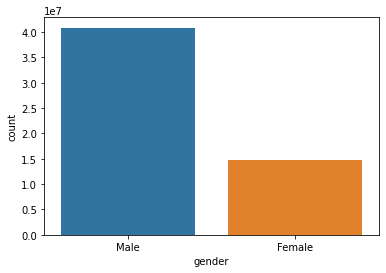

In [32]:
# Count plot no of males and females
rides['gender'].value_counts()
splot = sns.countplot('gender', data=rides)
splot.axes.set_xticklabels(['Male', 'Female'])
plt.show()

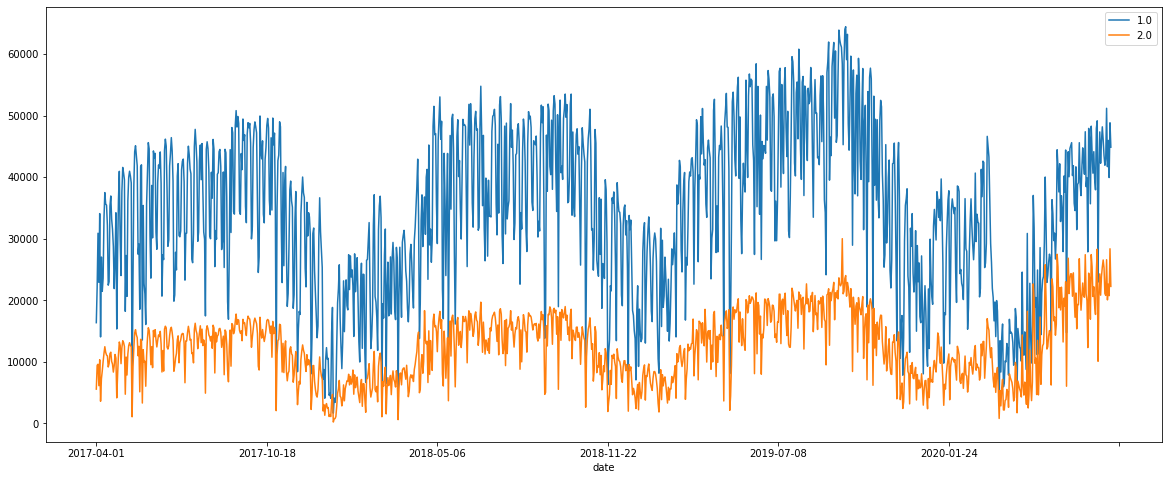

In [33]:
gender_df = rides.groupby(['date', 'gender']).size()
gender_df = gender_df.to_frame()
gender_df = gender_df.reset_index()
gender_df.columns = ['date', 'gender', 'count']
fig, ax = plt.subplots()
for label, grp in gender_df.groupby('gender'):
    grp.plot(x = 'date', y = 'count',ax = ax, label = label, figsize=(20,8))

Bike Accident Forecasting

In [38]:
path = '/content/drive/My Drive/CMPE 255 Project/data/bike_accidents/accident_count_agg.csv'
num_bike_collisions = pd.read_csv(path)
num_bike_collisions['date'] = pd.to_datetime(num_bike_collisions['date'], infer_datetime_format=True)
num_bike_collisions

,date,num_crashes
0,2016-03-08,2
1,2016-03-09,1
2,2016-03-11,1
3,2016-03-12,2
4,2016-03-13,5
...,...,...
1674,2020-10-09,27
1675,2020-10-10,13
1676,2020-10-11,17
1677,2020-10-12,13


In [39]:
num_bike_collisions = num_bike_collisions.merge(weather_features, left_on='date', right_on='Date').drop(['Date'], axis=1)
num_bike_collisions = num_bike_collisions.fillna(num_bike_collisions.mean())
num_bike_collisions = num_bike_collisions.rename(columns={'date':'ds', 'num_crashes':'y'})
num_bike_collisions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


,ds,y,TMAX,TMIN,PRCP,SNOW,AWND,SNWD,WDF2,WDF5,WSF2,WSF5
0,2016-03-08,2,194,83,0,0.0,15.00000,0,170.000000,170.000000,63.00000,85.000000
1,2016-03-09,1,250,67,0,0.0,10.00000,0,240.000000,210.000000,45.00000,98.000000
2,2016-03-11,1,200,89,15,0.0,27.00000,0,40.000000,10.000000,76.00000,116.000000
3,2016-03-12,2,150,44,0,0.0,23.00000,0,250.000000,250.000000,67.00000,103.000000
4,2016-03-13,5,167,100,0,0.0,16.00000,0,30.000000,30.000000,54.00000,81.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1662,2020-09-27,31,261,194,8,0.0,22.07978,0,191.894231,194.937111,60.57761,98.586731
1663,2020-09-28,23,250,206,5,0.0,22.07978,0,191.894231,194.937111,60.57761,98.586731
1664,2020-09-29,21,233,194,119,0.0,22.07978,0,191.894231,194.937111,60.57761,98.586731
1665,2020-09-30,27,217,156,290,0.0,28.00000,0,270.000000,160.000000,76.00000,121.000000


In [40]:
holdout_period = 365
max_date = num_bike_collisions[['ds']].max()
split_date = max_date - timedelta(days=holdout_period)
split_date = split_date[0].strftime('%Y-%m-%d')
train = num_bike_collisions.loc[num_bike_collisions.ds <= split_date].copy()
test = num_bike_collisions.loc[num_bike_collisions.ds > split_date].copy()
print(split_date)

2019-10-02


In [41]:
# Split Date into 180 days
holdout_period = 180
max_date = num_bike_collisions[['ds']].max()
six_month_date = max_date - timedelta(days=holdout_period)
six_month_date = six_month_date[0].strftime('%Y-%m-%d')
train = num_bike_collisions.loc[num_bike_collisions.ds <= split_date].copy()
test = num_bike_collisions.loc[num_bike_collisions.ds > split_date].copy()
print(six_month_date)

2020-04-04


Train and test data split



In [43]:
# Test set 1 year
X0 = num_bike_collisions.drop(['ds','y'], axis=1)
y0 = num_bike_collisions['y']
train = num_bike_collisions.loc[num_bike_collisions.ds <= split_date].copy()
test = num_bike_collisions.loc[num_bike_collisions.ds > split_date].copy()
X0_train = train.drop(['ds', 'y'], axis=1)
y0_train = train['y']
X0_test = test.drop(['ds', 'y'], axis=1)
y0_test = test['y']

In [42]:
# Test set 180 days 
X1 = num_bike_collisions.drop(['ds', 'y'], axis=1)
y1 = num_bike_collisions['y']
train = num_bike_collisions.loc[num_bike_collisions.ds <= six_month_date].copy()
test = num_bike_collisions.loc[num_bike_collisions.ds > six_month_date].copy()
X_train = train.drop(['ds', 'y'], axis=1)
y_train = train['y']
X_test = test.drop(['ds', 'y'], axis=1)
y_test = test['y']

ＲＦ

In [ ]:
rf_random.fit(X_train, y_train)
# RF for 1year
model0 = rf_random.best_estimator_

# Train the model using the training sets
model0.fit(X0_train, y0_train)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [75]:
# RF for 180days
model = rf_random.best_estimator_

# Fit to the data
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=80, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Prediction

In [73]:
y_pred0 = model0.predict(X0_test)

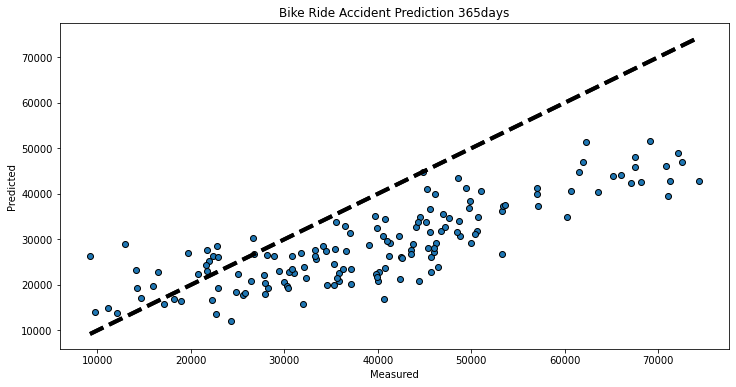

In [74]:
# Plot Prediction for (365 days) 
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(y0_test, y_pred0, edgecolors=(0, 0, 0))
ax.plot([y0_test.min(), y0_test.max()], [y0_test.min(), y0_test.max()], 'k--', lw=4)
ax.plot([y0_test.min(), y0_test.max()], [y0_test.min(), y0_test.max()], 'k--', lw=4)
ax.set_title('Bike Ride Accident Prediction 365days')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [76]:
# Predicting # of collision given date/weather features (180days)
y_pred = model.predict(X_test)

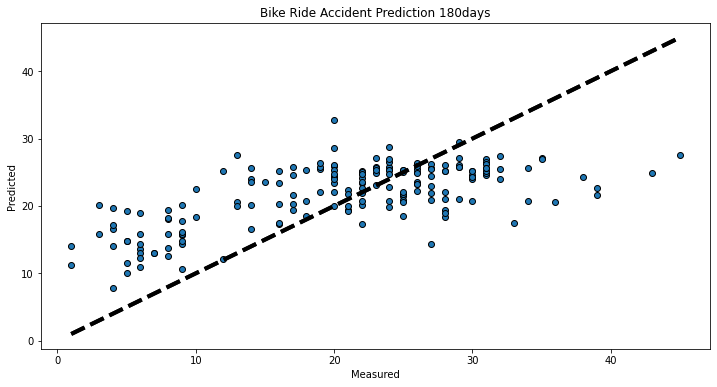

In [77]:
# Plot Prediction for (180 days) 
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_title('Bike Ride Accident Prediction 180days')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Model evaluation 1year and 180days¶


In [78]:
# Metric Evaluation Results for 365 days
scores = cross_val_score(model0, X0_test, y0_test, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


print('R square: %.3f' % r2_score(y0_test, y_pred0))
print('MSE:', metrics.mean_squared_error(y0_test, y_pred0))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y0_test, y_pred0)))
print('MAE:', mean_absolute_error(y0_test, y_pred0))
print('MAPE:', np.mean(np.abs((y0_test - y_pred0) / y0_test)))
print('MDAPE:', np.median(np.abs((y0_test - y_pred0) / y0_test)))

Accuracy: -0.06 (+/- 2.09)
R square: 0.128
MSE: 199172370.96580505
RMSE: 14112.844184139674
MAE: 12161.85713222222
MAPE: 0.3075965440275282
MDAPE: 0.30170184179744036


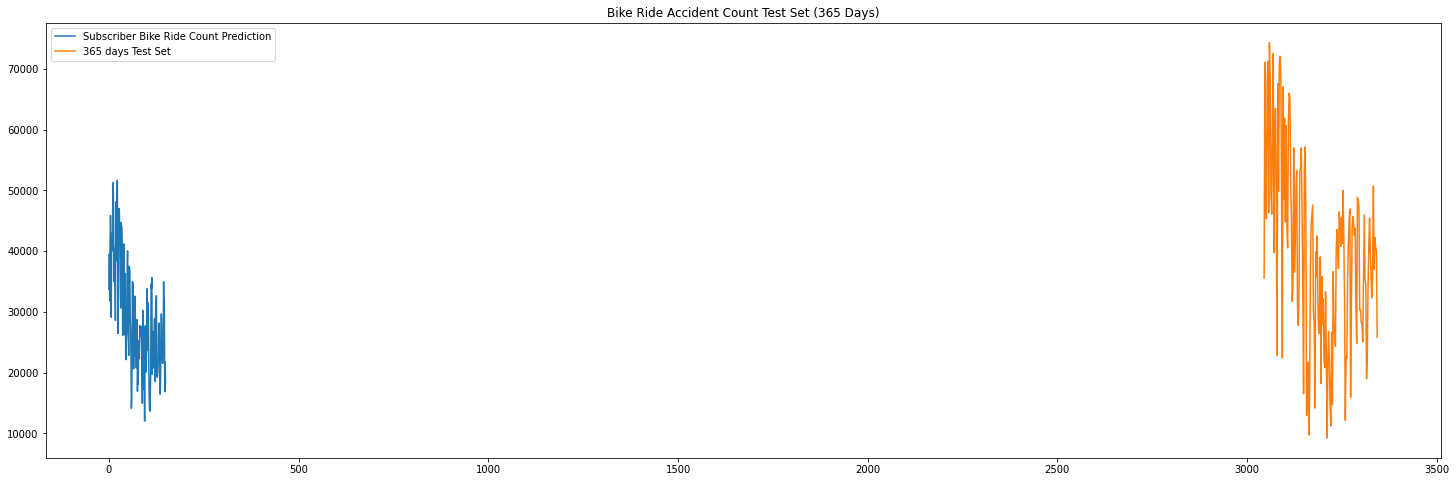

In [80]:
fig, ax = plt.subplots(figsize=(25,8))
ax.plot(y_pred0, label='Subscriber Bike Ride Count Prediction')
ax.plot(y0_test,label='365 days Test Set')
plt.title('Bike Ride Accident Count Test Set (365 Days)')
ax.legend()

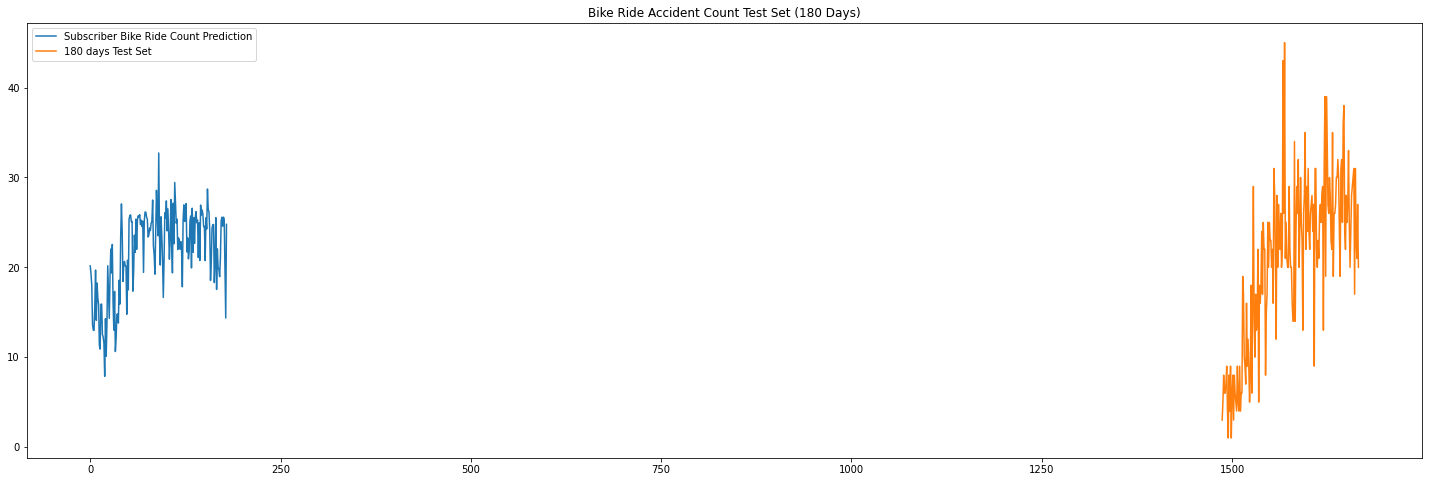

In [81]:
fig, ax = plt.subplots(figsize=(25,8))
ax.plot(y_pred, label='Subscriber Bike Ride Count Prediction')
ax.plot(y_test,label='180 days Test Set')
plt.title('Bike Ride Accident Count Test Set (180 Days)')
ax.legend()